# Tumor Recognition and Classification System Using CNN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###### Importing Libraries

In [2]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


###### Unzipping Data and Getting Data Ready

In [3]:
# Unzip the data
#!unzip "/content/drive/MyDrive/Tumor Recognition and Classification System/archive.zip" -d "/content/drive/MyDrive/Tumor Recognition and Classification System/Dataset"

In [4]:
def DataFrame(path):
    images = []
    labels = []
    for subfolder in os.listdir(path):
        subfolder_path = os.path.join(path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_filename)
            images.append(image_path)
            labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

train_df = DataFrame('/content/drive/MyDrive/Tumor Recognition and Classification System/Dataset/Training')
train_df = shuffle(train_df, random_state = 42)
train_df

,image,label
1700,/content/drive/MyDrive/Tumor Recognition and C...,meningioma
3269,/content/drive/MyDrive/Tumor Recognition and C...,notumor
561,/content/drive/MyDrive/Tumor Recognition and C...,glioma
5465,/content/drive/MyDrive/Tumor Recognition and C...,pituitary
5460,/content/drive/MyDrive/Tumor Recognition and C...,pituitary
...,...,...
3772,/content/drive/MyDrive/Tumor Recognition and C...,notumor
5191,/content/drive/MyDrive/Tumor Recognition and C...,pituitary
5226,/content/drive/MyDrive/Tumor Recognition and C...,pituitary
5390,/content/drive/MyDrive/Tumor Recognition and C...,pituitary


In [5]:
ts_df = DataFrame('/content/drive/MyDrive/Tumor Recognition and Classification System/Dataset/Testing')
ts_df = shuffle(ts_df, random_state = 42)
ts_df

,image,label
1120,/content/drive/MyDrive/Tumor Recognition and C...,pituitary
1072,/content/drive/MyDrive/Tumor Recognition and C...,pituitary
198,/content/drive/MyDrive/Tumor Recognition and C...,glioma
575,/content/drive/MyDrive/Tumor Recognition and C...,meningioma
331,/content/drive/MyDrive/Tumor Recognition and C...,meningioma
...,...,...
1095,/content/drive/MyDrive/Tumor Recognition and C...,pituitary
1130,/content/drive/MyDrive/Tumor Recognition and C...,pituitary
1294,/content/drive/MyDrive/Tumor Recognition and C...,pituitary
860,/content/drive/MyDrive/Tumor Recognition and C...,notumor


###### Preparing Data

In [6]:
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [7]:
# cropped image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'image', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'image', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'image', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


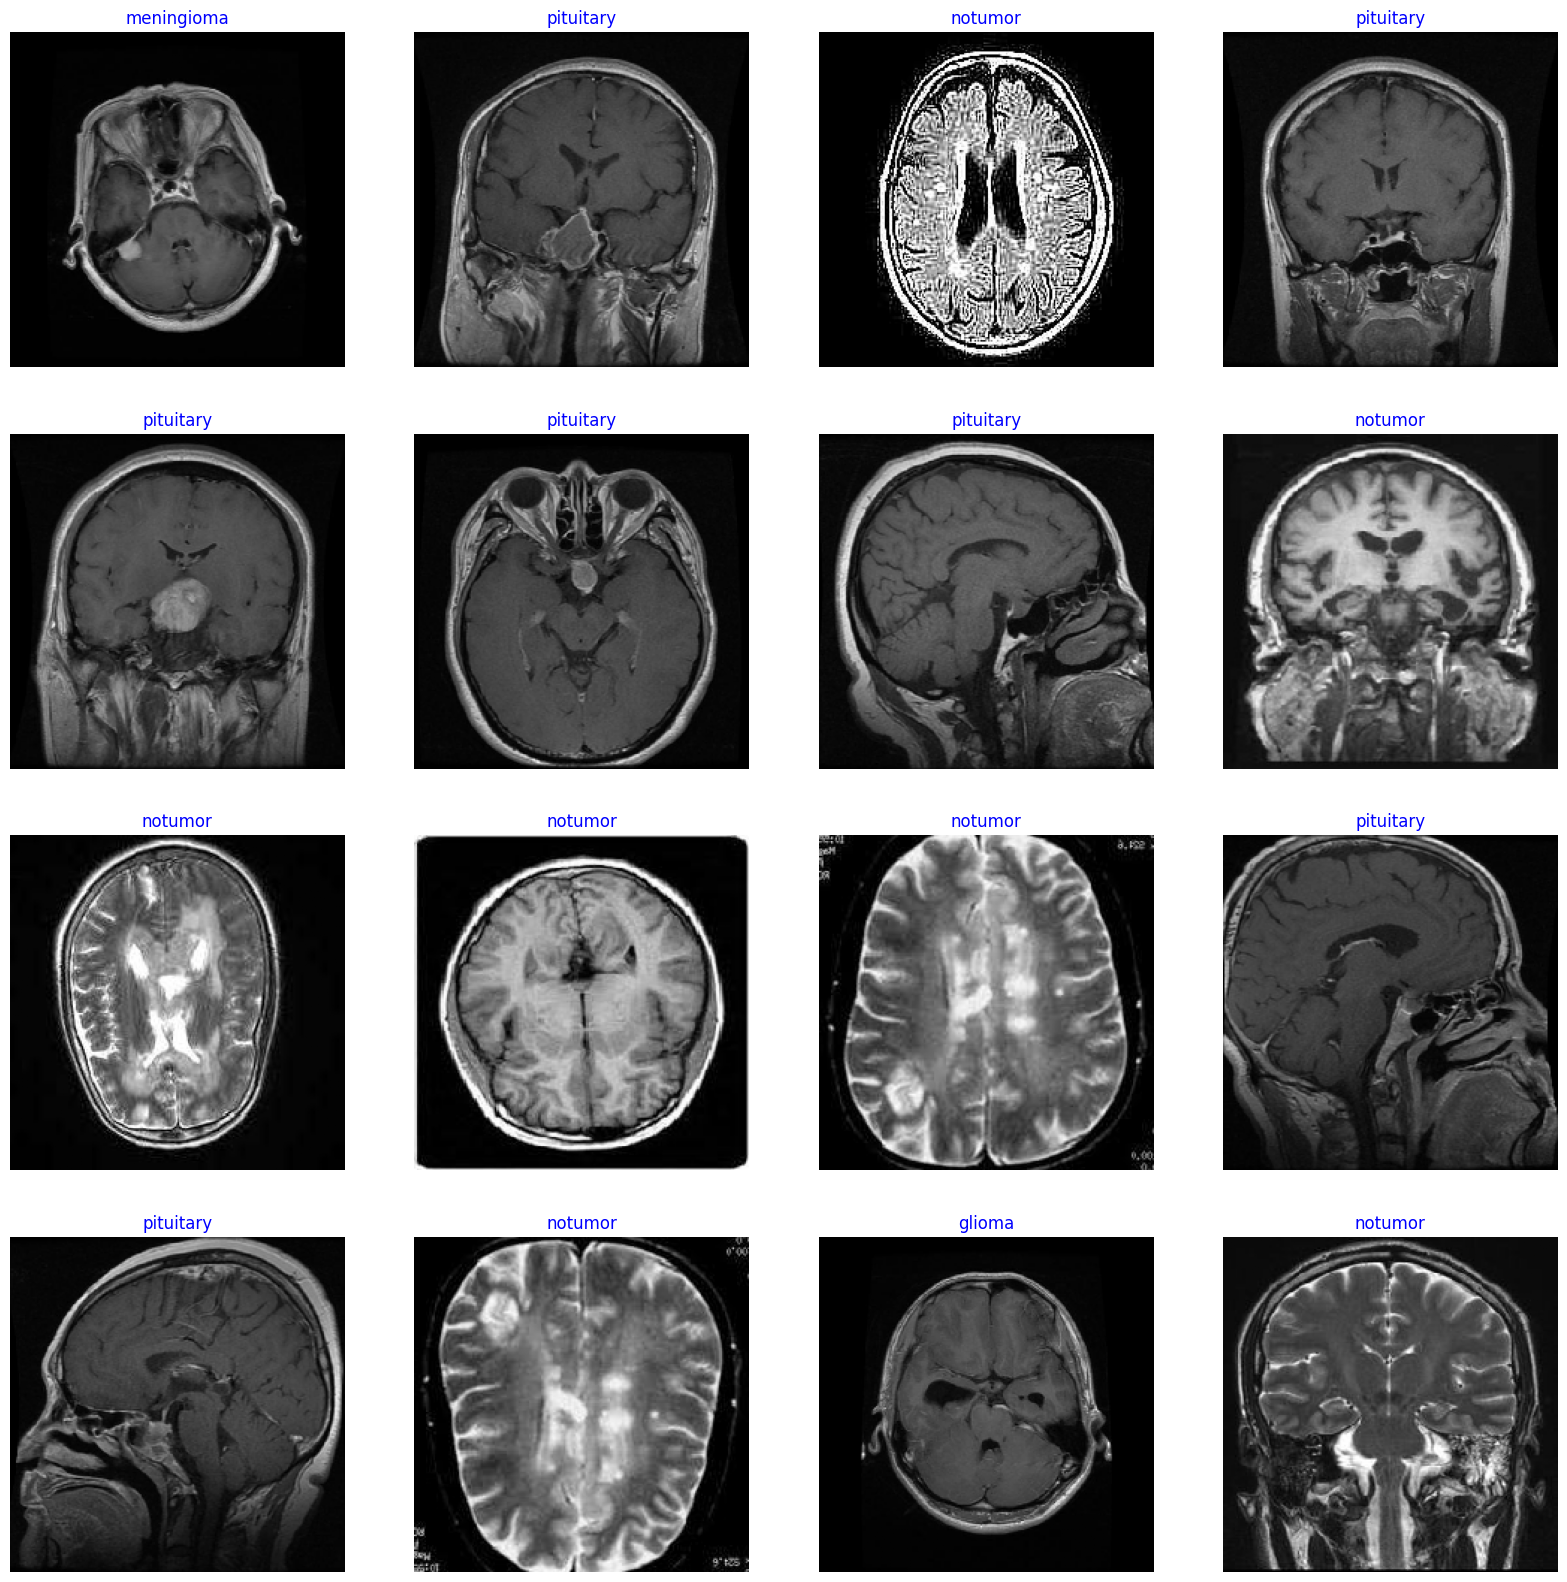

In [8]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

###### Build Model

In [9]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11184179 (42.66 MB)
Trainable params: 1109

###### Train Model

In [10]:
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/10
357/357 [==============================] - 164s 291ms/step - loss: 5.9677 - accuracy: 0.8757 - val_loss: 4.0526 - val_accuracy: 0.9695
Epoch 2/10
357/357 [==============================] - 99s 278ms/step - loss: 2.9828 - accuracy: 0.9576 - val_loss: 2.0614 - val_accuracy: 0.9817
Epoch 3/10
357/357 [==============================] - 99s 277ms/step - loss: 1.5522 - accuracy: 0.9734 - val_loss: 1.0382 - val_accuracy: 0.9924
Epoch 4/10
357/357 [==============================] - 100s 279ms/step - loss: 0.8097 - accuracy: 0.9814 - val_loss: 0.5666 - val_accuracy: 0.9878
Epoch 5/10
357/357 [==============================] - 99s 278ms/step - loss: 0.4664 - accuracy: 0.9856 - val_loss: 0.3319 - val_accuracy: 0.9908
Epoch 6/10
357/357 [==============================] - 100s 279ms/step - loss: 0.3043 - accuracy: 0.9914 - val_loss: 0.2472 - val_accuracy: 0.9908
Epoch 7/10
357/357 [==============================] - 99s 278ms/step - loss: 0.2398 - accuracy: 0.9891 - val_loss: 0.1991 - val

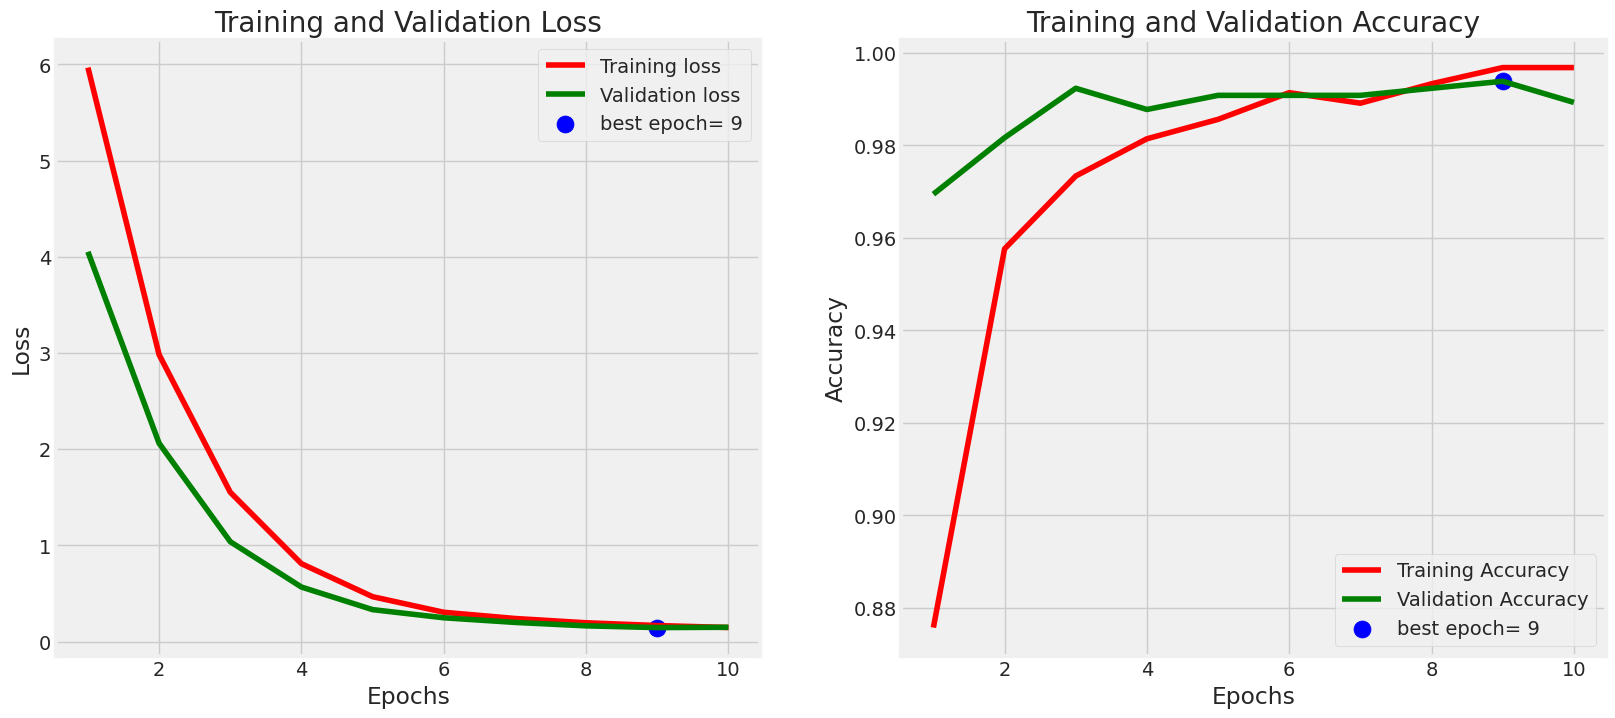

In [11]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

###### Evaluate Model

In [12]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 1s 75ms/step - loss: 0.1513 - accuracy: 0.9922
Train Loss:  0.13032817840576172
Train Accuracy:  1.0
--------------------
Validation Loss:  0.129551962018013
Validation Accuracy:  0.99609375
--------------------
Test Loss:  0.15130174160003662
Test Accuracy:  0.9921875


###### Generate Predictions

In [13]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

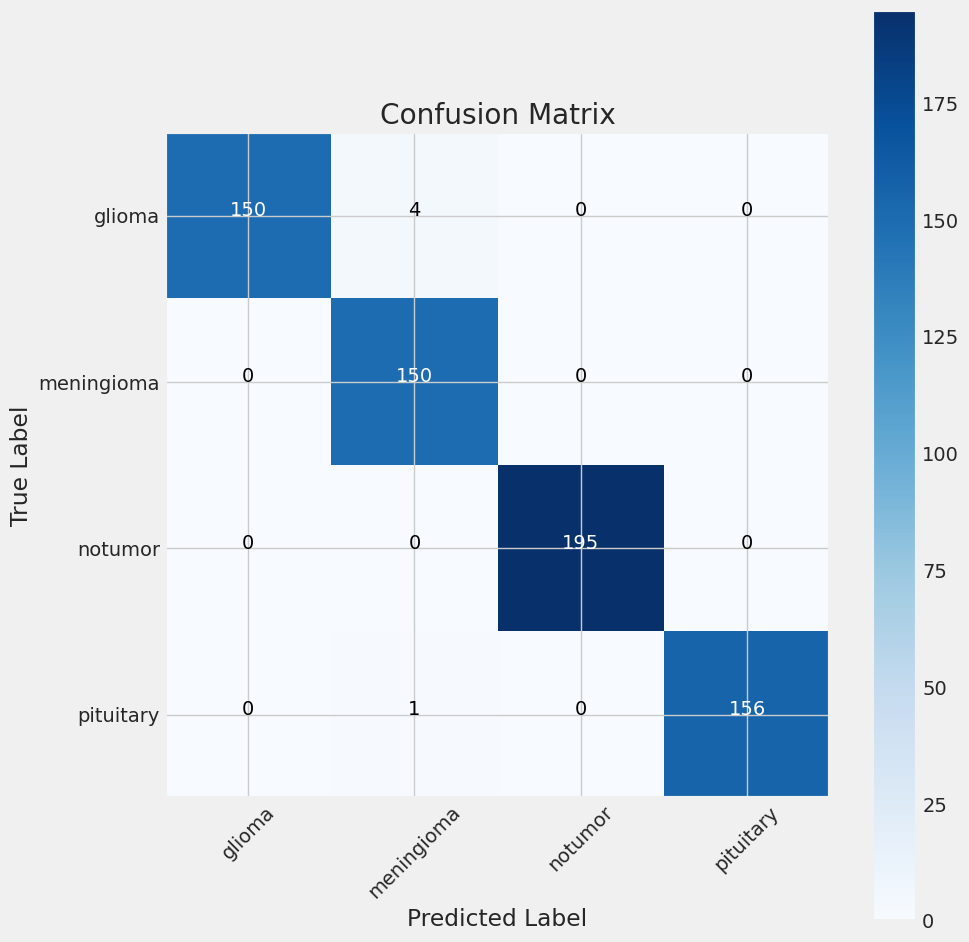

['glioma', 'meningioma', 'notumor', 'pituitary']

In [33]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()
classes

In [16]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       1.00      0.97      0.99       154
  meningioma       0.97      1.00      0.98       150
     notumor       1.00      1.00      1.00       195
   pituitary       1.00      0.99      1.00       157

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



###### Save Model

In [29]:
#Save the model
model_name = model.input_names[0][:-8]
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'tumor_{model_name}({"%.2f" %round(acc, 2)}).h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'tumor_{model_name}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as tumor_efficientnet(99.22).h5
weights were saved as tumor_efficientnet-weights.h5


### Deployment

In [30]:
pip install streamlit

In [1]:
# importing the libraries and dependencies needed for creating the UI and supporting the deep learning models used in the project
import streamlit as st
import tensorflow as tf
import random
from PIL import Image, ImageOps
import numpy as np
from tensorflow.keras.models import load_model
import numpy as np

from tensorflow.keras.preprocessing.image import load_img, img_to_array

from PIL import Image

# hide deprication warnings which directly don't affect the working of the application
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set some pre-defined configurations for the page, such as the page title, logo-icon, page loading state (whether the page is loaded automatically
# or you need to perform some action for loading)
st.set_page_config(
    page_title="Brain Tumor Recognition and Classification",
    initial_sidebar_state = 'auto'
)

st.caption("Upload an image. ")

st.caption("The application will infer the one label out of 4 labels: 'Glioma', 'Meningioma', 'Healthy', 'Pituitary'.")

st.caption("Warning: Do not click Recognize button before uploading image. It will result in error.")


model = load_model("tumor_efficientnet(99.22).h5")

# Define the class names

class_names = ['Glioma', 'Meningioma', 'Healthy', 'Pituitary']

# Fxn

@st.cache

def load_image(image_file):

        img = Image.open(image_file)

        return img


imgpath = st.file_uploader("Choose a file", type =['png', 'jpeg', 'jpg'])

if imgpath is not None:

    img = load_image(imgpath )

    st.image(img, width=224)



def predict_label(image2):

    imgLoaded = load_img(image2, target_size=(224, 224))

    # Convert the image to an array
    img_array = img_to_array(imgLoaded)    #print(img_array)


    #print(img_array.shape)
    img_array = np.reshape(img_array, (1, 255, 255, 3))


    # Get the model predictions
    predictions = model.predict(img_array)

    #print("predictions:", predictions)
    # Get the class index with the highest predicted probability
    class_index = np.argmax(predictions[0])

    # Get the predicted class label
    predicted_label = class_names[class_index]

    return predicted_label

if st.button('Recognise'):

    predicted_label = predict_label(imgpath)

    st.write("The image is predicted to be '{}'.".format(predicted_label))

2023-12-02 09:38:59.832 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]


In [3]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 0.415s

3 packages are looking for funding
  run `npm fund` for details

found 2 moderate severity vulnerabilities
  run `npm audit fix` to fix them, or `npm audit` for details


In [4]:
!npm audit fix

npm ERR! code EAUDITNOPJSON
npm ERR! audit No package.json found: Cannot audit a project without a package.json

npm ERR! A complete log of this run can be found in:
npm ERR!     /root/.npm/_logs/2023-12-02T09_40_37_341Z-debug.log


In [5]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password/Enpoint IP for localtunnel is: 34.42.45.83


In [7]:
!streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py &>/content/logs.txt &

In [8]:
!npx localtunnel --port 8501

npx: installed 22 in 2.228s
your url is: https://floppy-lizards-flow.loca.lt
^C
